## Improving CIFAR-10 Images Results

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import tensorflow.keras.backend as K

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

K.clear_session()

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# get the data: shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

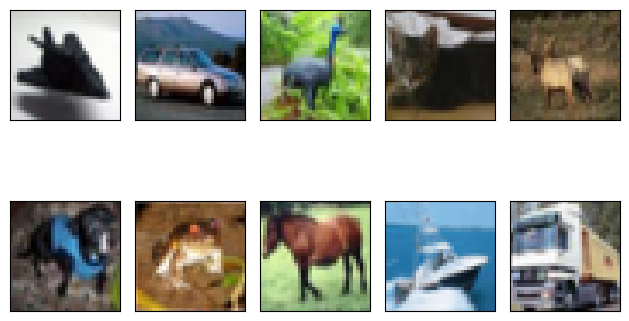

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[np.where(y_train==i)[0][0]]/255.
    ax[i].imshow(img, interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show();

## Building a Deeper Model

In [2]:
# CIFAR_10 is a set of 60K images 32x32 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS, IMG_COLS = 32, 32
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)

EPOCHS = 50
NUM_CLASSES = 10

In [3]:
def load_data():
    (X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    # normalize
    mean = np.mean(X_train, axis=(0,1,2,3))
    std = np.std(X_train, axis=(0,1,2,3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
 
    y_train =  tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test =  tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

    return X_train, y_train, X_test, y_test

One way to improve the performance is to define a deeper network with multiple convolutional operations. In the following example, we have a sequence of modules:

* 1st module: (CONV+CONV+MaxPool+DropOut)
* 2nd module: (CONV+CONV+MaxPool+DropOut)
* 3rd module: (CONV+CONV+MaxPool+DropOut)

These are followed by a standard dense output layer. All the activation functions used are ReLU functions. Also `BatchNormalization()` can be used to introduce regularization.

In [4]:
def build_model():
    model = models.Sequential()

    # 1st block
    model.add(layers.Conv2D(32, (3,3), padding='same', 
                            activation='relu', 
                            input_shape=INPUT_SHAPE))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))

    # 2nd Block
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    # 3rd Block
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    # dense
    model.add(layers.Flatten())
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    
    return model

In [5]:
# Get the data
X_train, y_train, X_test, y_test = load_data()

# Build the model
model = build_model()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='RMSProp',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [9]:
# Fit the model
BATCH_SIZE = 64

history = model.fit(X_train, y_train, verbose=1,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    workers=8, use_multiprocessing=True)

Epoch 1/50
782/782 [==============================] - 13s 12ms/step - loss: 1.7739 - accuracy: 0.4689 - val_loss: 1.2741 - val_accuracy: 0.5992
Epoch 2/50
782/782 [==============================] - 9s 11ms/step - loss: 1.0989 - accuracy: 0.6481 - val_loss: 1.0572 - val_accuracy: 0.6424
Epoch 3/50
782/782 [==============================] - 9s 11ms/step - loss: 0.8759 - accuracy: 0.7102 - val_loss: 0.7656 - val_accuracy: 0.7436
Epoch 4/50
782/782 [==============================] - 9s 11ms/step - loss: 0.7483 - accuracy: 0.7470 - val_loss: 0.7240 - val_accuracy: 0.7654
Epoch 5/50
782/782 [==============================] - 9s 11ms/step - loss: 0.6662 - accuracy: 0.7730 - val_loss: 0.7963 - val_accuracy: 0.7491
Epoch 6/50
782/782 [==============================] - 9s 11ms/step - loss: 0.6024 - accuracy: 0.7956 - val_loss: 0.6989 - val_accuracy: 0.7650
Epoch 7/50
782/782 [==============================] - 9s 11ms/step - loss: 0.5496 - accuracy: 0.8119 - val_loss: 0.5697 - val_accuracy: 0.808

In [10]:
train_score = model.evaluate(X_train, y_train, verbose=1)
print(f"\nTrain score: {train_score[0]}")
print(f'Train accuracy: {train_score[1]}\n')

score = model.evaluate(X_test, y_test, verbose=1)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

1563/1563 [==============================] - 5s 3ms/step - loss: 0.0274 - accuracy: 0.9948

Train score: 0.02735321596264839
Train accuracy: 0.9947999715805054

313/313 [==============================] - 1s 4ms/step - loss: 0.5044 - accuracy: 0.8588

Test score: 0.5043935775756836
Test accuracy: 0.8587999939918518


## Improving CIFAR-10 Perf. with Data Augmentation

**Another way to improve the performance is to generate more images for our training. The idea here is that we can take the standard CIFAR training set and augment this set with multiple types of transformation, including rotation, rescaling, horizontal or vertical flip, zooming, channel shift, and many more.** 

Let's see the code applied on the same network defined in the previous section:

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image augmentation
datagen = ImageDataGenerator(rotation_range=30, 
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

datagen.fit(X_train)

- `rotation_range` is a value in degrees (0-180) for randomly rotating pictures;

- `width_shift` and `height_shift` are ranges for randomly translating pictures vertically or horizontally; 
- `zoom_range` is for randomly zooming pictures; 
- `horizontal_flip` is for randomly flipping half of the images horizontally; 
- `fill_mode` is the strategy used for filling in new pixels that can appear after a rotation or a shift.

In [7]:
# import scipy

# train
BATCH_SIZE = 64

model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
          epochs=EPOCHS, verbose=1,
          validation_data=(X_test, y_test),
          workers=8,)

Epoch 1/50
782/782 [==============================] - 32s 35ms/step - loss: 2.0738 - accuracy: 0.3713 - val_loss: 2.0112 - val_accuracy: 0.4183
Epoch 2/50
782/782 [==============================] - 27s 35ms/step - loss: 1.5576 - accuracy: 0.4956 - val_loss: 1.5442 - val_accuracy: 0.5513
Epoch 3/50
782/782 [==============================] - 27s 34ms/step - loss: 1.3388 - accuracy: 0.5553 - val_loss: 1.2998 - val_accuracy: 0.5877
Epoch 4/50
782/782 [==============================] - 27s 35ms/step - loss: 1.1805 - accuracy: 0.5959 - val_loss: 1.0266 - val_accuracy: 0.6480
Epoch 5/50
782/782 [==============================] - 27s 34ms/step - loss: 1.0768 - accuracy: 0.6268 - val_loss: 0.9678 - val_accuracy: 0.6850
Epoch 6/50
782/782 [==============================] - 27s 34ms/step - loss: 1.0051 - accuracy: 0.6557 - val_loss: 0.8801 - val_accuracy: 0.7017
Epoch 7/50
782/782 [==============================] - 27s 34ms/step - loss: 0.9507 - accuracy: 0.6748 - val_loss: 0.9025 - val_accuracy:

In [8]:
train_score = model.evaluate(X_train, y_train, verbose=1)
print(f"\nTrain score: {train_score[0]}")
print(f'Train accuracy: {train_score[1]}\n')

score = model.evaluate(X_test, y_test, verbose=1)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

1563/1563 [==============================] - 5s 3ms/step - loss: 0.4883 - accuracy: 0.8416

Train score: 0.48828765749931335
Train accuracy: 0.8416399955749512

313/313 [==============================] - 1s 4ms/step - loss: 0.5947 - accuracy: 0.8171

Test score: 0.5947104692459106
Test accuracy: 0.8170999884605408


In [11]:
import os

os.makedirs('./saved_model', exist_ok=True)

# Save the model to disk
model_json = model.to_json()

with open('saved_model/cifar_10_model_with_data_aug.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('saved_model/cifar_10_model_with_data_aug.h5')

## Predicting with CIFAR-10

In [1]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.transform import resize
# from imageio import imread
import imageio.v2 as imageio # imageio.imread

from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop

In [2]:
model_architecture = "saved_model/cifar_10_model_with_data_aug.json"
model_weights = "saved_model/cifar_10_model_with_data_aug.h5"

model = model_from_json(open(model_architecture).read())
model.load_weights(model_weights)

img_names = ["prediction_images/cat-standing.jpg", "prediction_images/dog.jpg"]

imgs = [resize(mpimg.imread(img_name).astype('float32'), (32,32))
        for img_name in img_names]

imgs = np.array(imgs)/255

print("imgs.shape:", imgs.shape)

OPTIMIZER = SGD()

model.compile(loss='categorical_crossentrropy', 
              optimizer=OPTIMIZER, metrics=['accuracy'])

prediction = model.predict(imgs)
print("predictions:", np.argmax(prediction, axis=-1))

imgs.shape: (2, 32, 32, 3)
1/1 [==============================] - 2s 2s/step
predictions: [3 5]


**We get categories 3 (cat) and 5 (dog) as output as expected.** We successfully 
created a ConvNet to classify CIFAR-IO images.t

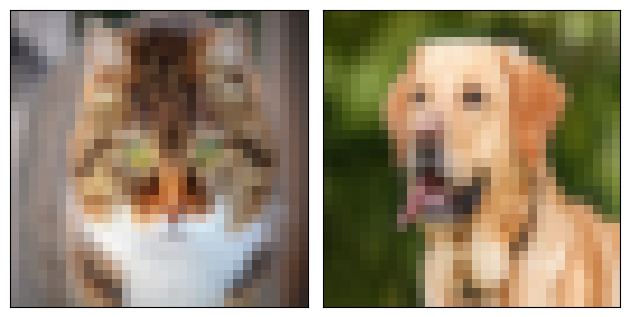

In [3]:
# plt.subplot(1,2,1)
# plt.imshow(imgs[0], interpolation='none')
# plt.axis('off')

# plt.subplot(1,2,2)
# plt.imshow(imgs[1], interpolation='nearest')
# plt.axis('off')

# plt.show();
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax = ax.flatten()

for i, img in enumerate(imgs):
    ax[i].imshow(img, interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show();